In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
data_path = "data/"

In [2]:
places = pd.read_csv(data_path + "places.csv", sep=";")
reviews = pd.read_csv(data_path + "reviews.csv", sep=";", low_memory=False)

## 1.2 Reviews

In [9]:
from datetime import datetime
import numpy as np
import re
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
nltk.download("stopwords")
_stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jesperhauch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
print("Shape of reviews:", reviews.shape)
reviews.isna().sum()

Shape of reviews: (571724, 8)


rating                 0
reviewerName        2139
reviewText        146604
categories         50096
gPlusPlaceId        3885
unixReviewTime     49070
reviewTime         50817
gPlusUserId         5632
dtype: int64

In [19]:
# Categories is essential for our future analysis. Hence we remove rows with missing categories
reviews.dropna(subset=["categories"], inplace=True)

In [20]:
# Only get reviews that are in the places list
reviews = reviews.loc[lambda x: x.gPlusPlaceId.isin(places.gPlusPlaceId.values)]

In [21]:
reviews.dtypes

rating             object
reviewerName       object
reviewText         object
categories         object
gPlusPlaceId       object
unixReviewTime    float64
reviewTime         object
gPlusUserId        object
dtype: object

In [22]:
# Convert rating to numeric feature
reviews['rating'] = pd.to_numeric(reviews['rating'], downcast="integer")

In [23]:
# Using unix review time since it has less missing values and more information than the review time feature
def unixToDatetime(unix_timestamp):
    if not pd.isna(unix_timestamp):
        return datetime.utcfromtimestamp(unix_timestamp).strftime("%Y-%m-%d %H:%M:%S")
    else:
        return np.NaN

reviews['unixReviewTime'] = reviews['unixReviewTime'].apply(unixToDatetime)
reviews.drop(["reviewTime"], axis=1, inplace=True)

In [24]:
# Categories are stored as a "['Category']", thus we use regex to find the word between the apostrophes
reviews['categories'] = reviews.categories.apply(lambda x: re.findall(r"[\[|\s]\'(.*?)\'[\,|\]]", x))

In [25]:
# Text processing function from Social Graphs and Interactions
def cleanString(text):
    if not pd.isna(text):
        tokens = word_tokenize(text) #Tokenizing
        punctuation = [word.lower() for word in tokens if word.isalnum()] # remove punctuation and set to lower case
        lemma = [lemmatizer.lemmatize(word) for word in punctuation] # lemmatize words
        stopwords = stopwords.words('english')
        return [w for w in lemma if w not in stopwords] # Finally removes stopwords
    else:
        return np.NaN

In [26]:
#reviews['reviewTextClean'] = reviews['reviewText'].apply(cleanString)
#reviews.to_csv(data_path + "reviews_cleaned.csv", index=False)

# Exploratory (Reviews)

In [203]:
reviews = pd.read_csv(data_path + "reviews_cleaned.csv")
places = pd.read_csv(data_path + "places_cleaned.csv")

In [204]:
reviews['categories'] = reviews.categories.apply(lambda x: re.findall(r"[\[|\s]\'(.*?)\'[\,|\]]", x))

In [205]:
reviews.reviewTextClean[0]

"['cute', 'hotel', 'good', 'amenity', 'nice', 'location', 'great', 'cranky', 'cocktail', 'staff', 'hotel', 'bar', 'second', 'floor', 'ugh', 'last', 'thing', 'need', 'trying', 'unwind', 'tightly', 'wound', 'sour', 'cocktail', 'waitress', 'delivering', '18', 'drink']"

Each business has the same categories attached to it across reviews. To ensure we have as few categories as possible, we will find the most popular categories across all reviews and assign the most popular category of the categories each business belongs to.

In [206]:
def findPopularCat(df):
    popular_dict = df.explode(column = "categories").groupby(["categories"]).count()['gPlusUserId'].to_dict()
    temp_df = df.drop_duplicates(subset="gPlusPlaceId").reset_index(drop=True)
    category_dict = {}
    for _, row in temp_df.iterrows():
        max_count = 0
        max_cat = ""
        for cat in row['categories']:
            count = popular_dict[cat]
            if count > max_count:
                max_count = count
                max_cat = cat
        category_dict[row['gPlusPlaceId']] = max_cat
    return category_dict

In [207]:
category_dict = findPopularCat(reviews)
places['category'] = places['gPlusPlaceId'].apply(lambda x: category_dict[x] if x in category_dict.keys() else np.NAN)

In [224]:
for city in places.city.unique():
    print(f"Top 5 categories for {city}")
    print(places[lambda x: x['city'] == city].category.value_counts().head(5))
    print()

Top 5 categories for London
Asian Restaurant       1482
Bar                    1346
Cafe                   1337
European Restaurant    1310
Pub                    1240
Name: category, dtype: int64

Top 5 categories for New York
European Restaurant    855
Asian Restaurant       847
American Restaurant    676
Bar                    613
Clothing Store         509
Name: category, dtype: int64



In [208]:
s = places.category.str.contains("Restaurant").values
restaurants = places.loc[np.nonzero(s)[0]].reset_index(drop=True)
restaurants[restaurants.price == 2].sample(10)

,gPlusPlaceId,name,price,lat,lon,city,address,category
102,104698941388952654212,"Hush Brasserie, St Paul's",2.0,51.513687,-0.100898,London,"['1', 'Ludgate Hill', 'London EC4M 7AA, United...",Restaurant
9189,105510857758934668310,Bombay Nights,2.0,51.554670,-0.196670,London,"['90 Fortune Green Rd', 'London NW6 1DS', 'Uni...",Asian Restaurant
3592,112087937134512168699,Balade,2.0,40.730293,-73.983098,New York,"['208 1st Ave', 'New York, NY 10009']",European Restaurant
9665,115583349153790445798,Biricchino,2.0,40.748816,-73.995372,New York,"['260 W 29th St', 'New York, NY 10001']",European Restaurant
6235,114751548485707816030,The Parlour,2.0,40.788438,-73.977106,New York,"['250 W 86th St', 'New York, NY 10024']",European Restaurant
1526,107221816672883434631,Lenny's,2.0,40.759453,-73.992077,New York,"['613 9th Ave', 'New York, NY 10036']",Fast Food Restaurant
6278,107349526742503296462,The Great British,2.0,51.513146,-0.153363,London,"['N Audley St', 'London W1K 6WT', 'United King...",European Restaurant
11289,105957518612656560929,Hundred Acres,2.0,40.727050,-74.002732,New York,"['38 Macdougal St', 'New York, NY 10012']",American Restaurant
5436,117761098393990865846,Uncle Boons,2.0,40.721289,-73.994373,New York,"['7 Spring St', 'New York, NY 10012']",Thai Restaurant
1031,116340574346185494522,Mizu,2.0,40.739019,-73.988999,New York,"['29 E 20th St', 'New York, NY 10003']",Japanese Restaurant


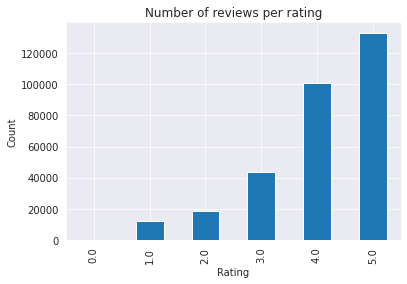

In [209]:
# Fjerne 0 rækker i reviews
reviews.rating.value_counts().sort_index().plot.bar(xlabel="Rating", ylabel="Count", title="Number of reviews per rating");

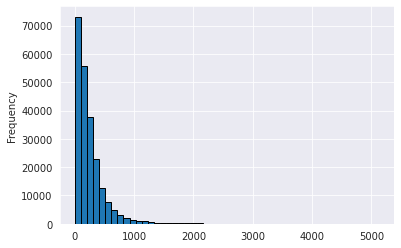

In [210]:
# Distribution of the amount of characters in the reviews
reviews.dropna(subset=["reviewTextClean"]).reviewTextClean.apply(len).plot.hist(bins=50, edgecolor="black", xlabel="Number of words");

<AxesSubplot:xlabel='unixReviewTime'>

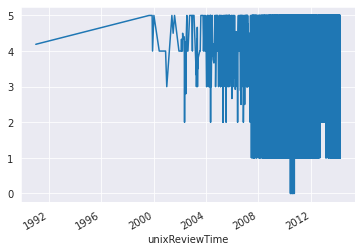

In [100]:
# fjern alt før 2000
temp_df = reviews.dropna(subset="unixReviewTime")
temp_df['unixReviewTime'] = pd.to_datetime(reviews['unixReviewTime'])
temp_df.groupby("unixReviewTime").mean()['rating'].sort_index().plot()